In [2]:
# Core python libraries
import csv
import re
import math
import os
import time

# External libraries.
import nltk
import numpy
import pandas
import scipy
import sklearn
import tempfile

# Tensorflow and related.
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt

# For dynamically reolading modules. imp.reload(module_name) 
import imp

# Internal libraries
import tf_utils

# So you know when this code block finishes.
print ("Done")

Done


In [3]:
#TODO(Max): make a library that does all this preprocessing
data = pandas.read_csv("data/train.csv") # Can read a subset. First nrows of the total.
LABEL_COLUMN = "SalaryNormalized"

TEST_SIZE = .3


print(len(data))

171482


In [4]:
# sklearn.cross_validation has been replaced with model_selection.
X_train_index, X_test_index, Y_train, Y_test = sklearn.model_selection.train_test_split(
    data.index, data[LABEL_COLUMN], test_size=TEST_SIZE, random_state=42)

# Keep train and test as pandas dataframes.
X_train = data.iloc[X_train_index]
X_test = data.iloc[X_test_index]

y_train = numpy.array(X_train[LABEL_COLUMN].astype(numpy.float32))
y_test = numpy.array(X_test[LABEL_COLUMN].astype(numpy.float32))

print ("Done")

Done


In [5]:
# Normalizing input values to mean 0, standard deviation 1.
train_mean, train_std = y_train.mean(), y_train.std()

# Normalize input labels and expectations
y_train = tf_utils.normalize_input(y_train, train_mean, train_std)
y_test = tf_utils.normalize_input(y_test, train_mean, train_std)


In [6]:
target_column = "CompleteJobListingStemmed"

x_train_text = X_train[target_column]
x_test_text = X_test[target_column]

In [7]:
min_word_frequency = 59

sklearn_bow = True # Otherwise we use Tensorflow BOW.

if sklearn_bow:
    # Gives 7600 unique words with min frequency 75 and stopwords removed.
    # 7797 if we leave stopwords in.

    count_vect = sklearn.feature_extraction.text.CountVectorizer(
        min_df=min_word_frequency, decode_error='ignore')

    # Transform BOW test set.
    x_train = count_vect.fit_transform(x_train_text)
    x_test = count_vect.transform(x_test_text)
    n_words = x_train.shape[1]
    max_document_length = n_words

else:
    # Look here for a tutorial https://medium.com/@ilblackdragon/tensorflow-text-classification-615198df9231
    # Gives 8712 unique words with min word frequency of 75
    vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(
        max_document_length, min_frequency=min_word_frequency)
    x_train = numpy.array(list(vocab_processor.fit_transform(x_train_text)))
    x_test = numpy.array(list(vocab_processor.transform(x_test_text)))
    n_words = len(vocab_processor.vocabulary_)
    max_document_length = max([len(x.split(" ")) for x in x_train_text])
    
print("x_train shape: %s, %s" % x_train.shape)
print("x_test shape: %s, %s" % x_test.shape)
print("Total distinct words: %d" % n_words)
print("Number of training rows: %d" % x_train.shape[0])

x_train shape: 120037, 8762
x_test shape: 51445, 8762
Total distinct words: 8762
Number of training rows: 120037


In [17]:
# Define data nput functions. These have to be done here as the 
# functions take no arguments. Also the dict labels are specific to 
# the model.
max_document_length = n_words

def input_fn():
    for batch_input, batch_labels in tf_utils.generate_batch(
        batch_size, number_of_batches, max_document_length,
                                                    x_train, y_train):
        yield {input_data: batch_input, input_target: batch_labels}

def eval_input_fn():
    for batch_input, batch_labels in tf_utils.generate_batch(
        batch_size, number_of_validation_batches, max_document_length,
                                                    x_test, y_test):
        yield {input_data: batch_input, input_target: batch_labels}


In [69]:
# Define model

graph = tf.Graph()

sess = tf.Session(graph=graph)

learning_rate = .01

l1_regularization_coef = 0.0 #1
l2_regularization_coef = 0.0 #1

# Implement this by batch.
batch_size = 2048

#(32,16,8) worked well
# (1024, 256, 64) Doesn't work
# (128, 32, 8) Neither
FIRST_LAYER_SIZE = 32
SECOND_LAYER_SIZE = 16
THIRD_LAYER_SIZE = 8

# Given small layers probably need this a little higher.
DROPOUT_KEEP_PROBABILITY = 0.8

with graph.as_default():

    with tf.name_scope("input_data"):
        # Initialize data placeholders
        input_data = tf.placeholder(shape=[batch_size, max_document_length], dtype=tf.float32)
        input_target = tf.placeholder(shape=[batch_size, 1], dtype=tf.float32, name="labels")

    with tf.device('/gpu:0'):

        with tf.name_scope("first_hidden_layer"):
            first_layer_hidden_units = tf.Variable(tf.truncated_normal(shape=[n_words, FIRST_LAYER_SIZE], stddev=.5))
            first_layer_bias = tf.Variable(tf.truncated_normal(shape=[1], stddev=.5))
            first_layer_product = tf.matmul(input_data, first_layer_hidden_units)
            first_layer_output = tf.contrib.layers.dropout(
                tf.nn.relu(tf.add(first_layer_product, first_layer_bias)), DROPOUT_KEEP_PROBABILITY)
            
        with tf.name_scope("second_hidden_layer"):
            second_layer_hidden_units = tf.Variable(tf.truncated_normal(shape=[FIRST_LAYER_SIZE, SECOND_LAYER_SIZE], stddev=.5))
            second_layer_bias = tf.Variable(tf.truncated_normal(shape=[1], stddev=.5))
            second_layer_product = tf.matmul(first_layer_output, second_layer_hidden_units)
            second_layer_output = tf.contrib.layers.dropout(
                tf.nn.relu(tf.add(second_layer_product, second_layer_bias)), DROPOUT_PROPORTION)
            
        with tf.name_scope("third_hidden_layer"):
            third_layer_hidden_units = tf.Variable(tf.truncated_normal(shape=[SECOND_LAYER_SIZE, THIRD_LAYER_SIZE], stddev=.5))
            third_layer_bias = tf.Variable(tf.truncated_normal(shape=[1], stddev=.5))
            third_layer_product = tf.matmul(second_layer_output, third_layer_hidden_units)
            third_layer_output = tf.contrib.layers.dropout(
                tf.nn.relu(tf.add(third_layer_product, third_layer_bias)), DROPOUT_KEEP_PROBABILITY)

        with tf.name_scope("output_layer"):
            output_layer_coefficients = tf.Variable(tf.truncated_normal(shape=[THIRD_LAYER_SIZE, 1], stddev=.5))
            output_layer_bias = tf.Variable(tf.truncated_normal(shape=[1], stddev=.5))
            output_layer_product = tf.matmul(third_layer_output, output_layer_coefficients)
            model_output = tf.add(output_layer_product, output_layer_bias, name="predictions")

    with tf.name_scope("loss"):
        # Mean Absolute Error.
        loss = tf.reduce_mean(tf.abs(tf.subtract(input_target, model_output)))

        # If we are using regularization.
        if l1_regularization_coef > 0 or l2_regularization_coef > 0:
            l1_regularizer = tf.contrib.layers.l1_regularizer(scale=l1_regularization_coef)
            l2_regularizer = tf.contrib.layers.l2_regularizer(scale=l2_regularization_coef)

            weights = tf.trainable_variables() # all vars of your graph
            regularization_penalty = tf.add(tf.contrib.layers.apply_regularization(l1_regularizer, weights),
                                             tf.contrib.layers.apply_regularization(l2_regularizer, weights))
            loss = loss + regularization_penalty # this loss needs to be minimized

    with tf.name_scope("reporting"):
        # Converts back to original, salary scale.
        error_salary_scale = tf.multiply(tf.subtract(input_target, model_output), train_std)

        mean_absolute_error_salary_scale = tf.reduce_mean(
            tf.abs(error_salary_scale))

        # Log for tensorboard
        training_summary = tf.summary.scalar('train_loss', loss)
        validation_summary = tf.summary.scalar('validation_loss', loss)
        # Add mean absolute errors.
        training_mae = tf.summary.scalar('train_mae', mean_absolute_error_salary_scale)
        validation_mae = tf.summary.scalar('validation_mae', mean_absolute_error_salary_scale)

    global_step = tf.Variable(0, name='global_step', trainable=False)

    # Declare optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)

    # This one seems to work better :D
    train_op = tf.contrib.layers.optimize_loss(      
     loss, tf.contrib.framework.get_global_step(),      
     optimizer='Adam'
        , learning_rate=learning_rate)


In [72]:
# Number of
number_of_epochs = 100
batches_per_epoch = len(x_train_text)/batch_size
number_of_batches = math.ceil(len(x_train_text)/batch_size)
number_of_validation_batches = number_of_batches

logs_dir = "logs/neuralnetbagofwords"

checkpoint_frequency = 250

reporting_frequency = 3

total_loss = 0
validation_loss = 0
validation_batch_average_window = 100

ckpt = None
ckpt = tf.train.get_checkpoint_state(logs_dir)  

In [21]:
# TF Queue Logic
"""
QUEUE_LIMIT = 500000

# Try me out
#batch_size = 256


with graph.as_default():
    queue = tf.RandomShuffleQueue(
        capacity=QUEUE_LIMIT, min_after_dequeue=batch_size,
        dtypes=[tf.float32, tf.float32],
        shapes = [(n_words,), (1,)],
        seed=1999)

    with tf.name_scope("preprocess_data"):
        with tf.device('/cpu:0'):

            # Initialize data placeholders
            x_data = tf.placeholder(shape=[batch_size, max_document_length], dtype=tf.int32)
            y_target = tf.placeholder(shape=[batch_size, 1], dtype=tf.float32, name="labels")
            #with tf.device('/cpu:0'):
            identity_mat = tf.diag(tf.ones(shape=[vocab_size]))
            # This is also an embedding_lookup_sparse function that would create a sparse tensor.
            x_embed = tf.nn.embedding_lookup(identity_mat, x_data)
            # Collapse across the document length dimension. Leaving only the number of tokens.
            example = tf.reduce_sum(x_embed, 1)

            enqueue_op = queue.enqueue_many((example, y_target))

        # Dequeue our data. Use dequeue_many(batch_size) later.
        dequeue_op = queue.dequeue_many(batch_size)

# Create 8 threads.
#qr = tf.train.QueueRunner(queue, [enqueue_op] * 8)
# Launch the graph.
with tf.Session(graph=graph) as session:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)


#sess = tf.Session()
    #enqueue_threads = qr.create_threads(sess, coord=coord, start=True)
    for step in range(10): # do to 100 iterations
        #if coord.should_stop():
        #    break
        #print(feed_dict)
        start_time = time.time()
        feed_dict = input_fn()
        #print(feed_dict)
        thing = session.run([enqueue_op], feed_dict=next(feed_dict))
        duration = time.time() - start_time
        print("Batch %s Enqueue Duration: %.4f" % (step +1, duration))
    coord.request_stop()
    coord.join(threads)
"""

<generator object input_fn at 0x7f4a9ca09a98>
Batch 1 Enqueue Duration: 7.1514
<generator object input_fn at 0x7f4a9e63a5c8>


KeyboardInterrupt: 

In [ ]:
with tf.Session(graph=graph) as session:
    #enqueue_threads = qr.create_threads(sess, coord=coord, start=True)
    for step in range(10): # do to 100 iterations
        #if coord.should_stop():
        #    break
        #print(feed_dict)
        data, label = session.run([dequeue_op])
        print(data)
        print(label)

In [73]:
# Where to save this model.
model_path = os.path.join(logs_dir, time.strftime("%Y-%m-%d-%H-%M-%S"))

if ckpt:
    restore_from_model = True
    print("Restore from model!")
else:
    restore_from_model = False

with tf.Session(graph=graph, config=tf.ConfigProto(
    allow_soft_placement=True, log_device_placement=True)) as session:
    summaries = tf.summary.merge_all()                                                       
    writer = tf.summary.FileWriter(model_path,
        graph=session.graph)                  

    saver = tf.train.Saver(tf.global_variables()) 
                                                                                                  
    session.run(tf.global_variables_initializer())
    
    
    if restore_from_model:
        saver.restore(session, ckpt.model_checkpoint_path)
        
    global_step = 0
        
    for epoch in range(number_of_epochs):
        eval_feed_generator = eval_input_fn()
        # Shuffle the training input
        x_train, y_train = tf_utils.unison_shuffled_copies(x_train, y_train)

        for step, feed_dict in enumerate(input_fn()):
            global_step += 1
            start_time = time.time()

            _, temp_loss = session.run([train_op, loss], feed_dict=feed_dict)
            
            duration = time.time() - start_time
            
            if global_step % reporting_frequency == 0:
                print("Epoch: %s Iteration: %s : Loss: %.4f (%.3f sec)" % 
                      (epoch, (step + 1), temp_loss, duration))

                train_summ, train_mae = session.run([training_summary, training_mae], feed_dict=feed_dict)
                writer.add_summary(train_summ, global_step)
                writer.add_summary(train_mae, global_step)
                _, valid_summ, valid_mae = session.run(
                        [loss, validation_summary, validation_mae],
                        feed_dict=next(eval_feed_generator))
                writer.add_summary(valid_summ, global_step)
                writer.add_summary(valid_mae, global_step)

                writer.flush()                

            if (global_step % checkpoint_frequency == 0) or (global_step == number_of_batches):
                print("Saving at epoch %s step: %s" % (epoch, step + 1))
                saver.save(session, model_path, global_step=tf.contrib.framework.get_global_step())

Restore from model!
INFO:tensorflow:Restoring parameters from logs/neuralnetbagofwords/2017-06-28-22-26-46-2750
Epoch: 0 Iteration: 3 : Loss: 0.2844 (0.037 sec)
Epoch: 0 Iteration: 6 : Loss: 0.3009 (0.037 sec)
Epoch: 0 Iteration: 9 : Loss: 0.3248 (0.039 sec)
Epoch: 0 Iteration: 12 : Loss: 0.3093 (0.036 sec)
Epoch: 0 Iteration: 15 : Loss: 0.2976 (0.037 sec)
Epoch: 0 Iteration: 18 : Loss: 0.3163 (0.053 sec)
Epoch: 0 Iteration: 21 : Loss: 0.3038 (0.060 sec)
Epoch: 0 Iteration: 24 : Loss: 0.3006 (0.057 sec)
Epoch: 0 Iteration: 27 : Loss: 0.3088 (0.053 sec)
Epoch: 0 Iteration: 30 : Loss: 0.3207 (0.042 sec)
Epoch: 0 Iteration: 33 : Loss: 0.3026 (0.049 sec)
Epoch: 0 Iteration: 36 : Loss: 0.3168 (0.038 sec)
Epoch: 0 Iteration: 39 : Loss: 0.3106 (0.037 sec)
Epoch: 0 Iteration: 42 : Loss: 0.2969 (0.037 sec)
Epoch: 0 Iteration: 45 : Loss: 0.3020 (0.036 sec)
Epoch: 0 Iteration: 48 : Loss: 0.3078 (0.049 sec)
Epoch: 0 Iteration: 51 : Loss: 0.3182 (0.047 sec)
Epoch: 0 Iteration: 54 : Loss: 0.3048 (0.

KeyboardInterrupt: 

In [49]:
# Model Evaluation
# number_of_validation_batches is used above in the eval_input_fn
number_of_validation_batches = math.floor(len(x_test_text)/batch_size)
# Load checkpointed model.
ckpt = tf.train.get_checkpoint_state(logs_dir)                                     

# Write TF Model Evaluation Code here. 
with tf.Session(graph=graph, config=tf.ConfigProto(
    allow_soft_placement=True, log_device_placement=True)) as session:
    
    saver = tf.train.Saver(tf.global_variables()) 
                                                                                                  
    session.run(tf.global_variables_initializer())
    
    saver.restore(session, ckpt.model_checkpoint_path)
    prediction_array_list = []

    total_loss = 0
    for step, eval_feed_dict in enumerate(eval_input_fn()):    
        valid_loss, mae, model_predictions = session.run(
            [loss, mean_absolute_error_salary_scale, model_output], feed_dict=eval_feed_dict)
        #print("Batch: %d Mean: %.4f" % (step, mae))
        total_loss += mae
        prediction_array_list.append(model_predictions)
    print ("Mean Absolute Error Loss over all %s observations = %s" % ((step + 1) * batch_size, total_loss / (step + 1)))

INFO:tensorflow:Restoring parameters from logs/neuralnetbagofwords/2017-06-28-21-25-42-5750
Mean Absolute Error Loss over all 51200 observations = 6890.73701172


In [50]:
def flatten_predictions(predictions):
    return numpy.concatenate(predictions)

predictions = flatten_predictions(prediction_array_list)

n_predictions = predictions.shape[0]

actuals = y_test[0:n_predictions]

print(n_predictions, actuals.shape)
print(y_test)

51200 (51200,)
[ 0.89645004 -0.66550416  3.22435188 ..., -0.29010177  0.89645004
  0.95295256]


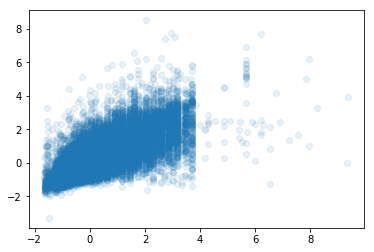

[[-1.2662046  -2.82815886  1.06169724 ...,  0.65487933 -2.19849539
  -2.53751016]
 [ 2.22026563  0.65831143  4.54816723 ...,  4.14134979  1.28797495
   0.94896007]
 [-4.18580246 -5.74775648 -1.85790062 ..., -2.26471853 -5.11809301
  -5.45710802]
 ..., 
 [-1.50738144 -3.0693357   0.8205204  ...,  0.41370249 -2.43967223
  -2.778687  ]
 [ 0.8513     -0.7106542   3.17920184 ...,  2.77238393 -0.0809907
  -0.42000553]
 [ 1.43651092 -0.12544328  3.76441288 ...,  3.35759497  0.50422019
   0.16520539]]


In [51]:
%matplotlib inline

def print_results(x_vals, y_vals):

    plt.scatter(x_vals, y_vals, alpha=.1)
    plt.show()

    print(x_vals-y_vals)
    #print(sorted([set(y_vals)]))

print_results(actuals, predictions)